# Intial Data Investigation

Here we'll investigate both train and test datasets for gaining more insight into the data in order to come up with right ideas for modelling phase.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# import our modules here
from modules.DataHandler import *
from modules.utils import *

# HandleData: used for downloading dataset (txt) files and handle the data we get
datahandler = DataHandler()

## 1. Balance of target clases

Unbalanced data will sure affect the predictive model and lead to a biased result. Thus, we'll check if class distribution in each dataset is balanced. If not, then we'll carry out necessary steps, such as oversampling or undersampling in pre-processing steps.

In [2]:
prefix = ['train', 'test']

for p in prefix:
    print('\n{}-SET\nclass\tnumber\t%-wise'.format(p.upper()))
    
    # load file
    data=datahandler.load_txt('UCI HAR Dataset/{}/y_{}.txt'.format(p, p))
    # count the number of occurance for each classes
    class_count = pd.value_counts(data.iloc[:,0])
    
    for c in range(len(class_count)):
        print('%d\t%d\t%.2f' %(class_count.index[c], 
                               class_count.values[c], 
                               100*class_count.values[c]/sum(class_count)))


TRAIN-SET
class	number	%-wise
6	1407	19.14
5	1374	18.69
4	1286	17.49
1	1226	16.68
2	1073	14.59
3	986	13.41

TEST-SET
class	number	%-wise
6	537	18.22
5	532	18.05
1	496	16.83
4	491	16.66
2	471	15.98
3	420	14.25


*It looks like distribution of our clsses is fairly normal. So it's safe to continue.*

## 2. Plot data

Pre-processed raw data had fixed windows of 2.56 seconds (128 data points) with a 50% overlap. For avoiding duplications due to overlapping in plotting, we'll remove overlaps and squash data frames it to the series. 

#### Load data

In [3]:
# GET TRAIN AND TEST RAW DATA

prefix = 'train'
X_train = datahandler.load_files('UCI HAR Dataset/{p}/Inertial Signals/'.format(p=prefix))
y_train = datahandler.load_txt('UCI HAR Dataset/{p}/y_{p}.txt'.format(p=prefix)).values

# get index that map rows to each subject in the dataset
sub_indices_train = datahandler.load_txt('UCI HAR Dataset/{p}/subject_{p}.txt'.format(p=prefix))


prefix = 'test'
X_test = datahandler.load_files('UCI HAR Dataset/{p}/Inertial Signals/'.format(p=prefix))
y_test = datahandler.load_txt('UCI HAR Dataset/{p}/y_{p}.txt'.format(p=prefix)).values

# get index that map rows to each subject in the dataset
sub_indices_test = datahandler.load_txt('UCI HAR Dataset/{p}/subject_{p}.txt'.format(p=prefix))

In [4]:
# PRINT DATA INFO

print('TRAIN\nX={}'.format(X_train.shape))
print('y={}'.format(y_train.shape))
print('activities={}'.format(np.unique(y_train)))
print('subjects={}\n'.format(np.unique(sub_indices_train)))

print('TEST\nX={}'.format(X_test.shape))
print('y={}'.format(y_test.shape))
print('activities={}'.format(np.unique(y_test)))
print('subjects={}'.format(np.unique(sub_indices_test)))

TRAIN
X=(7352, 128, 9)
y=(7352, 1)
activities=[1 2 3 4 5 6]
subjects=[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]

TEST
X=(2947, 128, 9)
y=(2947, 1)
activities=[1 2 3 4 5 6]
subjects=[ 2  4  9 10 12 13 18 20 24]


### 2.1 Plot time series of each inertial signals for a subject

In [144]:
# retrive all observations (rows) for a given subject id (we used id=1 for train and id=2 for test) 
sub_X_train = datahandler.get_subject_data(X_train, sub_indices_train, subject_id=1)
sub_y_train = datahandler.get_subject_data(y_train, sub_indices_train, subject_id=1)

sub_X_test = datahandler.get_subject_data(X_test, sub_indices_test, subject_id=2)
sub_y_test = datahandler.get_subject_data(y_test, sub_indices_test, subject_id=2)

# remove overlap
sub_X_train = datahandler.remove_overlap(sub_X_train)
sub_X_test  =  datahandler.remove_overlap(sub_X_test)

# print data info
print('sub_X_train={}'.format(sub_X_train.shape))
print('sub_X_test={}'.format(sub_X_test.shape))

sub_X_train=(21861, 9)
sub_X_test=(19026, 9)


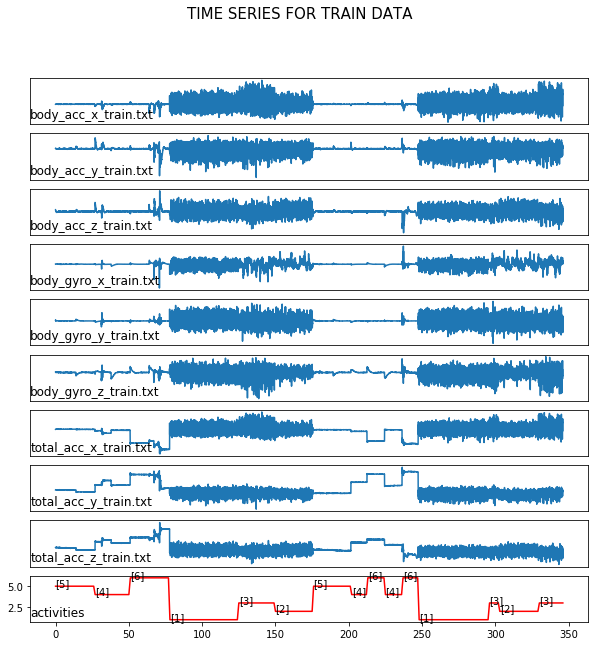

In [152]:
def plot_time_series(sub_data, signal_names, title):
    
    # create a subplot
    fig, ax = plt.subplots(nrows=len(signal_names)+1, ncols=1, figsize=(10,10), squeeze=True)

    # iterate over each signal
    for i in range(len(signal_names)):
        # add time series of corresponding inertial signal values
        ax[i].plot(sub_data[:, i])
        ax[i].set_title(signal_names[i], y=0, loc='left')
        # make axes unvisible
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)

    # add activity values to last ax
    ax[-1].plot(sub_y_train, 'r')
    ax[-1].set_title('activities', y=0, loc='left')
    
    # annotate activity number when there is a change
    temp_activity = 0
    for idx, activity in enumerate(sub_y_train): 
        if temp_activity!=activity: 
            temp_activity=activity
            ax[-1].annotate(str(activity), xy=(idx, activity))
    
    # add title and show plot
    fig.suptitle(title.upper(), fontsize=15)
    plt.show()
    
    
# get signal names 
signal_names = os.listdir('UCI HAR Dataset/train/Inertial Signals/')
# plot raw data 
plot_time_series(sub_X_train, signal_names, 'time series for train data')

As it's clear from the in the plot, periods with large fluctuations in sensor value correspond to walking activities (1: walking, 2: walking upstairs, 3: walking Downstairs). On the contrary, periods with fewer activity periods account for stationary activities (4: sitting, 5: standing, 6: laying). However, distribution of data for activities of same movement groups is similar to each, waking and stationary groups. This gives the idea that the raw feature can be helpful for classifying at least between walking activities and stationary activities. Yet, it also seems that, on the contrary to other inertial signals, total acceleration data on each axis can also be important for discriminating activities within the stationary group as it shows distinctive distribution upon activities of the same group. For a more detailed look, in the next step, we'll take a look at the histograms of each inertial signal per activity. 

### 2.2 Plot histogram of each inertial signals per the activity

## 3 Check for noises